In [0]:
# Packages for analysis
import pandas as pd
import numpy as np
from sklearn import svm
import zipfile

# Packages for visuals
import matplotlib.pyplot as plt
import seaborn as sn; sn.set(font_scale=1.2)


# Allows charts to appear in the notebook
%matplotlib inline

# Pickle package
import pickle

In [0]:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1UROh3KB6OO1VL96mRHo53bN5q3kPI8tU'
fluff, id = link.split('=')

As a dataset for multiclass classification the following data were chosen:
https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey

because
 - the dataset has a number of interesting parameters to explore;
 - the quality of the data is high;
 - the size of the dataset suggests that we can hope for high accuracy. 
 
 And it is about cosmic bodies, so it is quite romantic to explore! 

 So, **our goal** here is to classify celestial objects by types (stars, galaxies and quasars).

In [5]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Skyserver_SQL2_27_2018 6_51_39 PM.csv.zip') 
zf = zipfile.ZipFile('Skyserver_SQL2_27_2018 6_51_39 PM.csv.zip') 
start_data = pd.read_csv(zf.open('Skyserver_SQL2_27_2018 6_51_39 PM.csv')) 
start_data.rename(columns={"class": "typeobj"}, inplace = True)
start_data["typeobjid"] = start_data["typeobj"].factorize()[0]
start_data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,typeobj,redshift,plate,mjd,fiberid,typeobjid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491,0
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541,0
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513,1
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510,0
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512,0


**Content**

The data consists of 10,000 observations of space taken by the Sloan Digital Sky Survey (SDSS). Every observation is described by 17 feature columns and 1 class column ("typeobj") which identifies it to be either a star, galaxy or quasar. When downloading the dataset, we also added "typeobjid" column which shows numeric values that correspond to the type of the object: 0 for STAR, 1 for GALAXY, 2 for QUASAR.


**Basic Feature Description**

In the represented dataset we have  **photometric  measurements**:



> Right ascension (abbreviated *ra*) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated *dec*), these astronomical coordinates specify the direction of a point on the celestial sphere in the equatorial coordinate system.


And **spectral data**:


> *u, g, r, i, z* abbreviations stand for five filters used on the telescope. Each filter is designed to let in light around a specific wavelength. The filters work by blocking out light at all wavelengths except those around the wavelength they are designed to see.

- *u* for ultraviolet
- *g* for green
- *r* for red
- *i* for Near infrared
- *z* for Infrared

We are also provided with data relating to the details about processed images (*run, rereun, camcol, field*), but we will not use it as it has little to do with the type of the object.



# Random Forest 

We apply the random forest method from the `sklearn` package. To do so, we've picked a dataframe with spectral measurements as well as redshift values to create a pool of classification parameters.

In [18]:
X = start_data[['u','g','r','i','z','redshift']].as_matrix()
y = start_data.typeobjid

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=40)
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
model.score(X_test, y_test)

0.987

In [0]:
y_predicted = model.predict(X_test)

# Confusion Matrix

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted)
cm

array([[823,   1,   0],
       [  5, 993,  10],
       [  0,   8, 160]])

Text(63.5, 0.5, 'Truth')

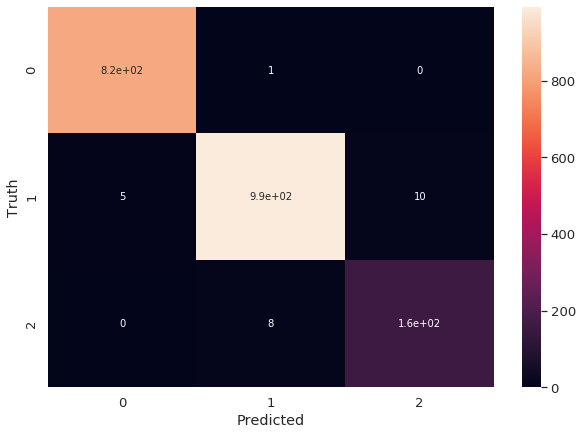

In [10]:
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Conclusions

The obtained accuracy in classification is noticably high due to 
- the big size of the dataset, which was split only in three classes;
- 

# Tuning the model with GridSearch

In [11]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 700]
}

# Instantiate the grid search model
from sklearn.ensemble import RandomForestRegressor

grid = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] max_depth=80, max_features=2, n_estimators=100 ..................
[CV]  max_depth=80, max_features=2, n_estimators=100, score=0.977, total=   0.8s
[CV] max_depth=80, max_features=2, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=80, max_features=2, n_estimators=100, score=0.978, total=   0.7s
[CV] max_depth=80, max_features=2, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=80, max_features=2, n_estimators=100, score=0.975, total=   0.7s
[CV] max_depth=80, max_features=2, n_estimators=200 ..................
[CV]  max_depth=80, max_features=2, n_estimators=200, score=0.976, total=   1.5s
[CV] max_depth=80, max_features=2, n_estimators=200 ..................
[CV]  max_depth=80, max_features=2, n_estimators=200, score=0.976, total=   1.5s
[CV] max_depth=80, max_features=2, n_estimators=200 ..................
[CV]  max_depth=80, max_features=2, n_estimators=200, score=0.975, total=   1.4s
[CV] max_depth=80, max_features=2, n_estimators=300 ..................
[CV]  max_depth=80, max_features=2, n_estimators=300, score=0.976, total=   2.3s
[CV] max_depth=80, max_features=2, n_estimators=300 ..................
[CV]  max_depth=80, max_features=2, n_estimators=300, score=0.976, total=   2.2s
[CV] max_depth=80, max_features=2, n_estimators=300 ..................
[CV]  max_depth=80, max_features=2, n_estimators=300, score=0.975, total=   2.1s
[CV] ma

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  4.4min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [80, 90, 100,

In [12]:
grid.best_params_

{'max_depth': 80, 'max_features': 3, 'n_estimators': 100}

In [13]:
best_model = RandomForestClassifier(max_depth= 80, max_features=3, n_estimators=100)
best_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=80, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
best_model.score(X_test, y_test)

0.9875

In [0]:
y_predictedbest = best_model.predict(X_test)

In [16]:
from sklearn.metrics import confusion_matrix
best_cm = confusion_matrix(y_test, y_predictedbest)
best_cm

array([[823,   1,   0],
       [  4, 994,  10],
       [  0,  10, 158]])

Text(63.5, 0.5, 'Truth')

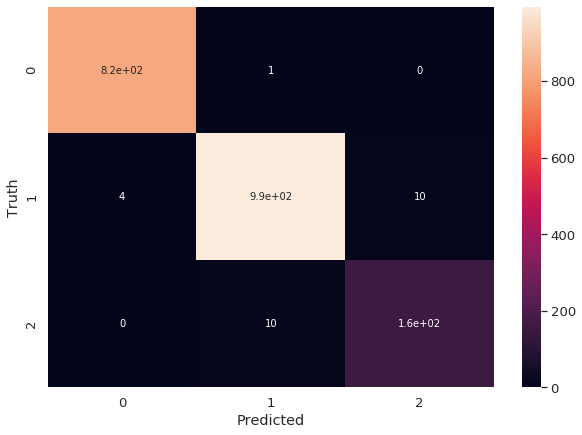

In [17]:
plt.figure(figsize=(10,7))
sn.heatmap(best_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')